In [1]:
import random
import math

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

import matplotlib.colors as mcolors
import matplotlib.cm as cm
from scipy.optimize import minimize

from typing import List, Optional, Tuple

# Human Capital Investments with Imperfect Credit Markets

In this model each individual lives for two periods. In the first time period he can choose to work or invest in education.

The indivual maximies a utility function

$$ u_t = (1-\delta) \log c_t + \delta \log b_t $$
$$ \text{s.t. } c_t + b_t \le y_t $$ 

The individual receives bequest $x_t$ from the previous generation. Let $h$ be the cost of education, $i$ be the borrowing rate and $r$ be the lending rate, with $i \gt r $ (which represents imperfect capital markets). 

1. If $x_t \gt h$, then the individual has enough wealth and will invest in education. 
2. Else, he will solve the utility maximisation problem above with the different income $y_t$ he earns under different decisions:

    If he invests in education, he will borrow at the rate $i$, and his income is $$y_t = (1+i)(x-h) + w_s $$

    If he does not invest in education and instead join the workforce immediately, his income is $$y_t = (1+r)(w_u+x) + w_u$$

    and choose the outcome with the higher utility. 


## Code

We have two classes, `Dynasty` which repesents each family line, and `ImperfectCreditMarket` representing the economy.

`Dynasty` can be instantiated as such:

```python
dynasty = Dynasty(x_0=100)
```


`ImperfectCreditMarket` can be instantiated with a list of dynasties:
```python
dynasties = [Dynasty(90), Dynasty(100)]

economy = ImperfectCreditMarket(dynasties)
economy.simulate(t=50)
economy.plot(with_gini=True)
```


In [ ]:
class Dynasty:
    def __init__(
        self,
        x_0: float = 100,
        *,
        delta: float = 0.8,
    ) -> None:
        """
        Initializes a Dynasty with initial wealth and discount factor.

        Parameters
        ----------
        x_0 : float, default=100
            Initial wealth of the dynasty.
        delta : float, default=0.8
            Discount factor for the utility function, indicating preference for future vs. current consumption.

        Examples
        --------
        >>> dynasty = Dynasty(x_0=150, delta=0.9)
        """
        self.w = []
        self.x = [x_0]
        self.delta = delta
        self.is_removed = False


    def utility_function(self, x: np.ndarray, args: float) -> float:
        """
        Computes the utility based on consumption decisions.

        Parameters
        ----------
        x : np.ndarray
            Array of size 1 representing bequest to next time period.
        args : float
            Total income available for consumption.

        Returns
        -------
        float
            Negative utility value (to minimize in optimization).
        """
        y = args
        b = x[0]
        return -((1 - self.delta) * np.log(y - b) + self.delta * np.log(b))


    def income_if_educated(self, w: float, ir: float, h: float) -> float:
        """
        Calculates income if the dynasty invests in education.

        Parameters
        ----------
        w : float
            Skilled wage.
        ir : float
            Interest rate, can be i if borrowing or r if lending.
        h : float
            Cost of education.

        Returns
        -------
        float
            Income after investment in education.
        """
        return max(0, w + (1 + ir) * (self.x[-1] - h))


    def income_if_not_educated(self, w: float, ir: float) -> float:
        """
        Calculates income if the dynasty does not invest in education.

        Parameters
        ----------
        w : float
            Unskilled wage.
        ir : float
            Interest rate on savings.

        Returns
        -------
        float
            Income without investment in education.
        """
        return (1 + ir) * (w + self.x[-1]) + w


    def education_decision(self, h: float, i: float, r: float, w_u: float, w_s: float) -> None:
        """
        Decides whether the dynasty invests in education based on exogenous parameters.

        Parameters
        ----------
        h : float
            Cost of education.
        i : float
            Borrowing rate.
        r : float
            Lending rate.
        w_u : float
            Unskilled wage.
        w_s : float
            Skilled wage.

        Returns
        -------
        None

        Examples
        --------
        >>> dynasty.education_decision(120, 0.05, 0.02, 10, 150)
        """
        if self.is_removed:
            self.w.append(np.nan)
            self.x.append(np.nan)
            return

        if self.x[-1] >= h:  # Invest in education
            y_n = self.income_if_educated(w_s, r, h)
            result_n = minimize(
                self.utility_function,
                [y_n / 2],
                bounds=[(0.01, y_n)],
                args=(y_n),
                method='SLSQP'
            )
            self.w.append(w_s)
            self.x.append(result_n.x[0])
        else:
            y_u = self.income_if_not_educated(w_u, r)
            y_s = self.income_if_educated(w_s, i, h)

            result_u = minimize(
                self.utility_function,
                [y_u / 2],
                bounds=[(0, y_u)],
                args=(y_u),
                method='SLSQP'
            )
            result_s = minimize(
                self.utility_function,
                [y_s / 2],
                bounds=[(0, y_s)],
                args=(y_s),
                method='SLSQP'
            )

            if result_u.fun < result_s.fun:  # Do not invest has higher utility
                self.w.append(w_u)
                self.x.append(result_u.x[0])
            else:
                self.w.append(w_s)
                self.x.append(result_s.x[0])


In [3]:
class ImperfectCreditMarket:
    def __init__(
        self,
        dynasties: Optional[List[Dynasty]] = None,
        h: int = 120,
        i: float = 0.52,
        r: float = 0.02,
        w_u: float = 10,
        w_s: float = 150,
        w_u_shocks: Optional[Tuple[float, float]] = None,
        w_s_shocks: Optional[Tuple[float, float]] = None,
    ) -> None:
        """
        Initializes the ImperfectCreditMarket class with initial parameters.
        
        Parameters
        ----------
        dynasties : list of Dynasty, optional
            List of Dynasty objects in the economy.
        h : int, default=120
            Cost of education.
        i : float, default=0.52
            Borrowing rate.
        r : float, default=0.02
            Lending rate.
        w_u : float, default=10
            Unskilled wage.
        w_s : float, default=150
            Skilled wage.
        w_u_shocks : tuple of float, optional
            Tuple of minimum and maximum unskilled wage shocks.
        w_s_shocks : tuple of float, optional
            Tuple of minimum and maximum skilled wage shocks.
        
        Examples
        --------
        >>> dynasties = [Dynasty(100), Dynasty(150)]
        >>> market = ImperfectCreditMarket(dynasties=my_dynasties)
        """
        assert i > r, 'Borrowing rate i has to be greater than lending rate r'
        self.dynasties = dynasties or []
        self.h = h
        self.i = i
        self.r = r
        self.w_u = w_u
        self.w_s = w_s
        self.gini = self._update_gini()
        self.t = 0
        self.w_u_shocks = w_u_shocks
        self.w_s_shocks = w_s_shocks

    def __repr__(self) -> str:
        return (
            f"ImperfectCreditMarket(h={self.h}, i={self.i}, r={self.r}, "
            f"w_u={self.w_u}, w_s={self.w_s}, gini={self.gini})"
        )

    def add_dynasties(self, dynasties: List[Dynasty]) -> None:
        """
        Adds new dynasty or list of dynasties to the market.
        
        Parameters
        ----------
        dynasties : list of Dynasty or Dynasty
            Single Dynasty or list of Dynasty objects to add.
        
        Raises
        ------
        TypeError
            If input is not a Dynasty or list of Dynasty objects.
        
        Examples
        --------
        >>> market.add_dynasties(new_dynasty)
        """
        if isinstance(dynasties, Dynasty):
            dynasties.w = [np.nan] * self.t
            dynasties.x = [np.nan] * self.t + [dynasties.x[0]]
            self.dynasties.append(dynasties)
        elif isinstance(dynasties, list):
            for dynasty in dynasties:
                if not isinstance(dynasty, Dynasty):
                    raise TypeError("Each item must be an instance of Dynasty.")
                dynasty.w = [np.nan] * self.t
                dynasty.x = [np.nan] * self.t + [dynasty.x[0]]
            self.dynasties.extend(dynasties)
        else:
            raise TypeError("Input should be a Dynasty object or a list of Dynasty objects.")


    def remove_dynasties(self, dynasties: List[Dynasty]) -> None:
        """
        Removes specified dynasties from the market.
        
        Parameters
        ----------
        dynasties : list of Dynasty or Dynasty
            Dynasty or list of Dynasty objects to remove.
        
        Examples
        --------
        >>> dynasties = [Dynasty(100), Dynasty(150)]
        >>> market = ImperfectCreditMarket(dynasties=my_dynasties)
        >>> market.remove_dynasties(dynasties[0])
        """
        dynasties = [dynasties] if isinstance(dynasties, Dynasty) else dynasties
        for dynasty in dynasties:
            if dynasty in self.dynasties:
                dynasty.is_removed = True


    def simulate(self, t: int) -> None:
        """
        Simulates the market for a given number of time steps.
        
        Parameters
        ----------
        t : int
            Number of time steps to simulate.
        
        Examples
        --------
        >>> market.simulate(10)
        """
        for _ in range(t):
            for dynasty in self.dynasties:
                w_u = max(0, self.w_u + random.uniform(*self.w_u_shocks)) if self.w_u_shocks else self.w_u
                w_s = max(0, self.w_s + random.uniform(*self.w_s_shocks)) if self.w_s_shocks else self.w_s
                dynasty.education_decision(self.h, self.i, self.r, w_u, w_s)
        self._update_gini()
        self.t += t


    def plot(self, use_wealth: bool = True, figsize: Tuple[int, int] = (10, 6), save: bool = False,
             save_name: str = 'human_capital.png', with_gini: bool = False, cmap=cm.viridis) -> None:
        """
        Plots wealth of dynasties over time.
        
        Parameters
        ----------
        use_wealth : bool, default=True
            If True, plot wealth; otherwise, plot income.
        figsize : tuple of int, default=(10, 6)
            Size of the plot.
        save : bool, default=False
            If True, saves the plot to a file.
        save_name : str, default='human_capital.png'
            File name for the saved plot.
        with_gini : bool, default=False
            If True, includes Gini coefficient plot.
        cmap : colormap, default=cm.viridis
            Matplotlib colormap for dynasty wealth color coding.
        
        Examples
        --------
        >>> market.plot(use_wealth=True, save=True)
        """
        fig, ax1 = plt.subplots(figsize=figsize)
        norm = mcolors.Normalize(vmin=30, vmax=160)

        # Iterate over each array in self.dynasties and plot it
        for index, dynasty in enumerate(self.dynasties):
            if use_wealth:
                color = next(x for x in dynasty.x if not math.isnan(x))
                ax1.plot(dynasty.x, color=cmap(norm(color)))
            else:
                ax1.plot(dynasty.w)

        ax1.set_xlabel('Time')
        ax1.set_ylabel('Wealth')
        ax1.set_title('Wealth over Time')
        ax1.tick_params(axis='y', left=False)

        ax1.spines['left'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        ax1.spines['top'].set_visible(False)
        ax1.grid(alpha=0.5)
        
        if with_gini:
            ax2 = ax1.twinx()  # Create a twin axis sharing the same x-axis
            ax2.plot(self.gini, color='orangered', label='Gini', linestyle='--')
            ax2.set_ylabel('Gini', color='orangered')
            ax1.tick_params(axis='y', left=False)
            ax2.tick_params(axis='y', right=False, colors='orangered')
            ax2.yaxis.set_major_locator(MaxNLocator(nbins=8, prune=None))
            ax2.spines['left'].set_visible(False)
            ax2.spines['right'].set_visible(False)
            ax2.spines['top'].set_visible(False)

        if save:
            plt.savefig(save_name, transparent=True)
        plt.show()


    def _update_gini(self, use_wealth: bool = True) -> None:
        """
        Updates the Gini coefficient based on current dynasty wealth or income.
        
        Parameters
        ----------
        use_wealth : bool, default=True
            If True, calculate Gini based on wealth; else use income.
        """
        values = np.array([dynasty.x for dynasty in self.dynasties]) if use_wealth else np.array([dynasty.w for dynasty in self.dynasties])
        self.gini = np.apply_along_axis(self._gini_coefficient, axis=0, arr=values)


    def _gini_coefficient(self, values: np.ndarray) -> float:
        """
        Calculates the Gini coefficient for a set of values. 
        Values should be of a single time period.
        
        Parameters
        ----------
        values : np.ndarray
            Array of values for calculating Gini coefficient.
        
        Returns
        -------
        float
            Calculated Gini coefficient.
        """
        sorted_values = sorted(values[~np.isnan(values)])
        n = len(sorted_values)
        mean_value = np.mean(sorted_values)
        
        numerator = sum((2 * i - n - 1) * xi for i, xi in enumerate(sorted_values, start=1))
        gini = numerator / (n ** 2 * mean_value)
        return abs(gini)


## Scenario 1

Fixed population, no changes to model parameters.

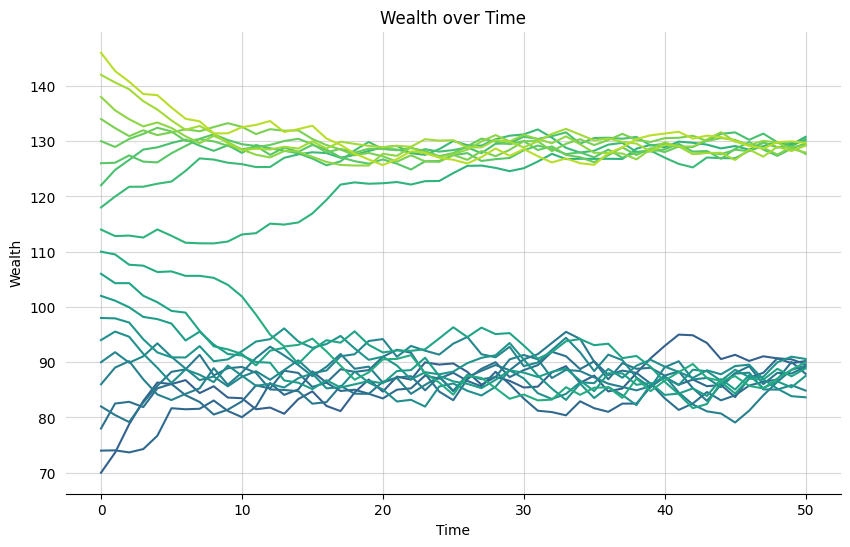

In [4]:
dynasties = [Dynasty(x_0) for x_0 in range(70, 150, 4)]

economy = ImperfectCreditMarket(dynasties, i=0.5, w_s=152, 
                                w_s_shocks=(-2, 2), w_u_shocks=(-2, 2))

economy.simulate(t=50)
economy.plot(with_gini=False)

## Scenario 2

Removal of high wealth families over time

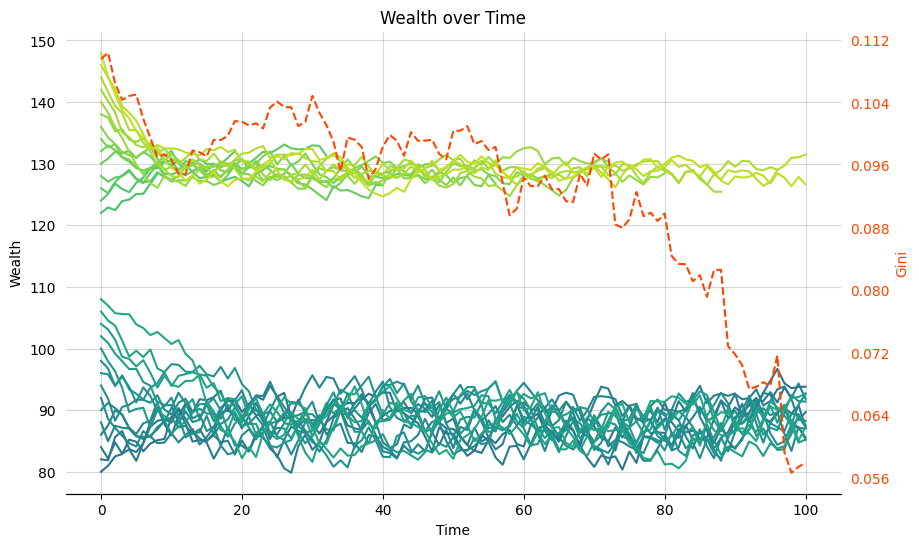

In [5]:
low_start = [Dynasty(x_0) for x_0 in range(80, 110, 2)]
high_start = [Dynasty(x_0) for x_0 in range(120, 150, 2)] 
dynasties =  [*low_start, *high_start]

economy = ImperfectCreditMarket(dynasties, i=0.5, w_s=152, w_s_shocks=(-2, 2), w_u_shocks=(-2, 2))

for t in range(50):
    if t % 2 == 0:
        economy.remove_dynasties(high_start[t//4])
    economy.simulate(2)


economy.plot(with_gini=True)

## Scenario 3

Adding of low wealth dynasties.

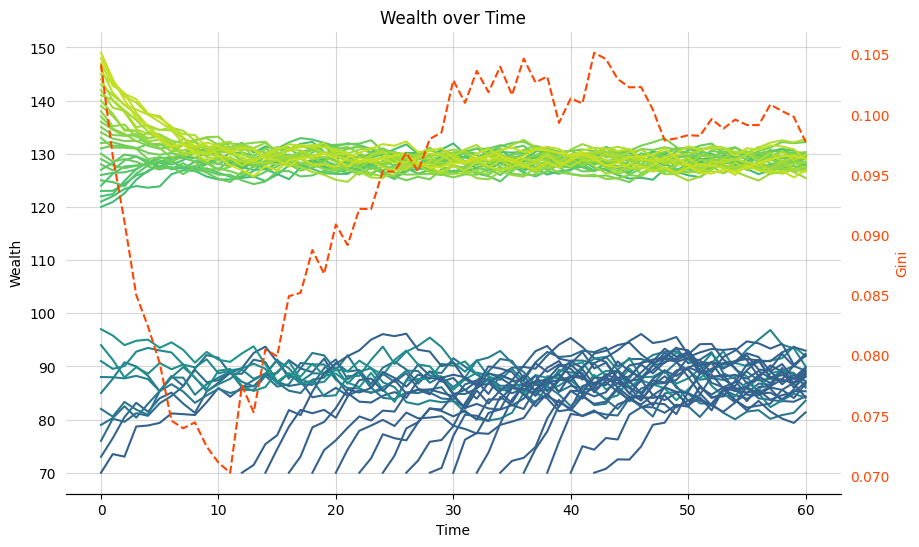

In [6]:
low_start = [Dynasty(x_0) for x_0 in range(70, 100, 3)]
high_start = [Dynasty(x_0) for x_0 in range(120, 150)] 
dynasties =  [*low_start, *high_start]

economy = ImperfectCreditMarket(dynasties, i=0.5, w_s=152, w_s_shocks=(-2, 2), w_u_shocks=(-2, 2))

economy.simulate(10)  # To let the economy stabilise

for t in range(25):
    economy.simulate(2)
    if t <= 15:
        new_low_start = Dynasty(x_0=70)
        economy.add_dynasties(new_low_start)

economy.plot(with_gini=True)

## Scenario 4

Reduction in cost of education at $ t=25 $.

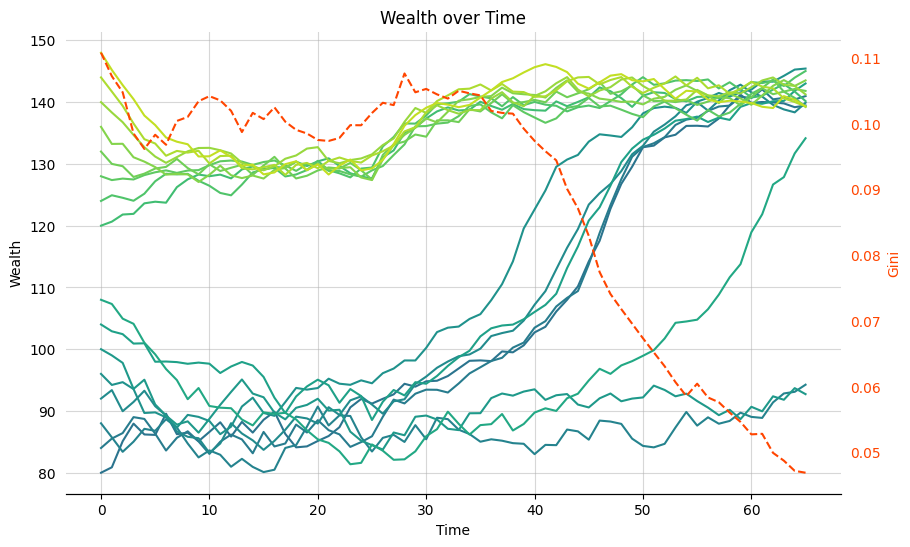

In [7]:
low_start = [Dynasty(x_0) for x_0 in range(80, 110, 4)]
high_start = [Dynasty(x_0) for x_0 in range(120, 150, 4)] 
dynasties =  [*low_start, *high_start]

economy = ImperfectCreditMarket(dynasties, i=0.5, w_s=152, w_s_shocks=(-2, 2), w_u_shocks=(-2, 2))

economy.simulate(25)
economy.h = 117.2
economy.simulate(40)

economy.plot(with_gini=True)

## Scenario 5

Continous adding of low wealth dynasties from $t=15$ to $t=40$, and decrease in cost of education h 3 times. 

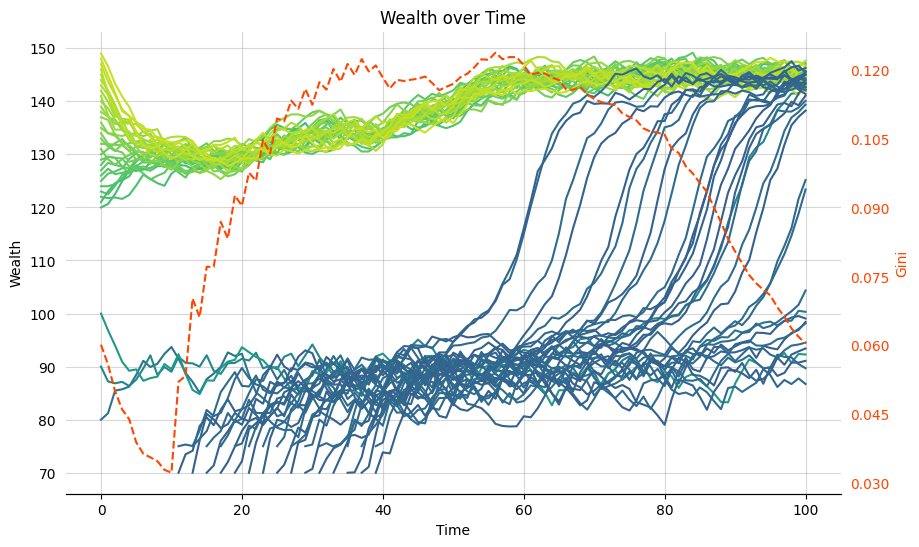

In [45]:
low_start = [Dynasty(x_0) for x_0 in range(80, 110, 10)]
high_start = [Dynasty(x_0) for x_0 in range(120, 150)] 
dynasties =  [*low_start, *high_start]

economy = ImperfectCreditMarket(dynasties, i=0.5, w_s=152, w_s_shocks=(-2, 2), w_u_shocks=(-2, 2))

economy.simulate(10)  # To let the economy stabilise

for t in range(10, 100):

    # Modify model parameters
    if t in [20, 40, 50]:
        economy.h -= 1.2
        economy.i += 0.02
        
    economy.simulate(1)

    # Add new low wealth families
    if t < 40 and t % 2 == 0:
        new_low_start = [Dynasty(x_0) for x_0 in (70, 75)]
        economy.add_dynasties(new_low_start) 

economy.plot(with_gini=True)